In [1]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
from sklearn.datasets import load_boston

In [3]:
data = load_boston()

In [4]:
losses = []

In [5]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 136.582
Epoch: 101, Loss: 6.581
Epoch: 201, Loss: 5.802
Epoch: 301, Loss: 5.007
Epoch: 401, Loss: 3.898
Epoch: 501, Loss: 4.510
Epoch: 601, Loss: 3.523
Epoch: 701, Loss: 4.123
Epoch: 801, Loss: 4.534
Epoch: 901, Loss: 3.737
Epoch: 1001, Loss: 3.937
Epoch: 1101, Loss: 4.296
Epoch: 1201, Loss: 4.045
Epoch: 1301, Loss: 4.403
Epoch: 1401, Loss: 3.912
Epoch: 1501, Loss: 3.839
Epoch: 1601, Loss: 4.392
Epoch: 1701, Loss: 3.884
Epoch: 1801, Loss: 3.798
Epoch: 1901, Loss: 4.551
Epoch: 2001, Loss: 4.339
Epoch: 2101, Loss: 4.251
Epoch: 2201, Loss: 3.358
Epoch: 2301, Loss: 4.748
Epoch: 2401, Loss: 3.570
Epoch: 2501, Loss: 3.477
Epoch: 2601, Loss: 3.311
Epoch: 2701, Loss: 3.643
Epoch: 2801, Loss: 4.686
Epoch: 2901, Loss: 3.505
Epoch: 3001, Loss: 3.921
Epoch: 3101, Loss: 3.406
Epoch: 3201, Loss: 3.568
Epoch: 3301, Loss: 3.531
Epoch: 3401, Loss: 3.695
Epoch: 3501, Loss: 3.307
Epoch: 3601, Loss: 3.459
Epoch: 3701, Loss: 3.409
Epoch: 3801, Loss: 4.096
Epoc

In [6]:
import matplotlib.pyplot as plt

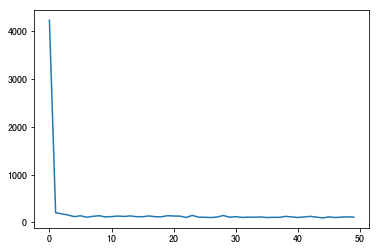

In [7]:
plt.plot(range(len(losses)), losses)

In [8]:
W2.value

array([[12.95526956],
       [ 4.44502603],
       [-6.94135244],
       [ 7.44602655],
       [ 6.97476219],
       [ 9.96077996],
       [ 5.41560844],
       [ 9.18734159],
       [ 6.82344011],
       [ 4.8044769 ]])

In [9]:
X_ = data['data']

In [10]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [11]:
import keras

Using TensorFlow backend.


In [12]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [13]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.fit(X_, y_, epochs=1000, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
506/506 [==============================] - 0s 209us/step - loss: 147.1745 - mean_squared_error: 147.1745
Epoch 2/1000
506/506 [==============================] - 0s 21us/step - loss: 83.8460 - mean_squared_error: 83.8460
Epoch 3/1000
506/506 [==============================] - 0s 20us/step - loss: 82.3513 - mean_squared_error: 82.3513
Epoch 4/1000
506/506 [==============================] - 0s 21us/step - loss: 83.4382 - mean_squared_error: 83.4382
Epoch 5/1000
506/506 [==============================] - 0s 22us/step - loss: 82.3099 - mean_squared_error: 82.3099
Epoch 6/1000
506/506 [==============================] - 0s 21us/step - loss: 82.7377 - mean_squared_error: 82.7377
Epoch 7/1000
506/506 [==============================] - 0s 21us/step - loss: 81.6347 - mean_squared_error: 81.6347
Epoch 8/1000
506/506 [==============================] - 0s 20us/step - loss: 80.5546 - mean_squared_error: 80.5546
Epoch 9/1000
506/506 [=======

506/506 [==============================] - 0s 21us/step - loss: 86.4844 - mean_squared_error: 86.4844
Epoch 70/1000
506/506 [==============================] - 0s 19us/step - loss: 85.3675 - mean_squared_error: 85.3675
Epoch 71/1000
506/506 [==============================] - 0s 19us/step - loss: 85.3642 - mean_squared_error: 85.3642
Epoch 72/1000
506/506 [==============================] - 0s 21us/step - loss: 85.2408 - mean_squared_error: 85.2408
Epoch 73/1000
506/506 [==============================] - 0s 19us/step - loss: 85.3192 - mean_squared_error: 85.3192
Epoch 74/1000
506/506 [==============================] - 0s 19us/step - loss: 84.2569 - mean_squared_error: 84.2569
Epoch 75/1000
506/506 [==============================] - 0s 19us/step - loss: 84.3601 - mean_squared_error: 84.3601
Epoch 76/1000
506/506 [==============================] - 0s 21us/step - loss: 85.5991 - mean_squared_error: 85.5991
Epoch 77/1000
506/506 [==============================] - 0s 19us/step - loss: 86.3414 

506/506 [==============================] - 0s 20us/step - loss: 85.7324 - mean_squared_error: 85.7324
Epoch 140/1000
506/506 [==============================] - 0s 19us/step - loss: 85.6550 - mean_squared_error: 85.6550
Epoch 141/1000
506/506 [==============================] - 0s 20us/step - loss: 85.3312 - mean_squared_error: 85.3312
Epoch 142/1000
506/506 [==============================] - 0s 21us/step - loss: 85.0253 - mean_squared_error: 85.0253
Epoch 143/1000
506/506 [==============================] - 0s 19us/step - loss: 85.1306 - mean_squared_error: 85.1306
Epoch 144/1000
506/506 [==============================] - 0s 19us/step - loss: 85.1500 - mean_squared_error: 85.1500
Epoch 145/1000
506/506 [==============================] - 0s 19us/step - loss: 84.8030 - mean_squared_error: 84.8030
Epoch 146/1000
506/506 [==============================] - 0s 20us/step - loss: 85.4510 - mean_squared_error: 85.4510
Epoch 147/1000
506/506 [==============================] - 0s 19us/step - loss: 

506/506 [==============================] - 0s 20us/step - loss: 84.2799 - mean_squared_error: 84.2799
Epoch 210/1000
506/506 [==============================] - 0s 22us/step - loss: 84.0050 - mean_squared_error: 84.0050
Epoch 211/1000
506/506 [==============================] - 0s 21us/step - loss: 84.7665 - mean_squared_error: 84.7665
Epoch 212/1000
506/506 [==============================] - 0s 22us/step - loss: 85.0873 - mean_squared_error: 85.0873
Epoch 213/1000
506/506 [==============================] - 0s 20us/step - loss: 84.2550 - mean_squared_error: 84.2550
Epoch 214/1000
506/506 [==============================] - 0s 21us/step - loss: 84.5711 - mean_squared_error: 84.5711
Epoch 215/1000
506/506 [==============================] - 0s 21us/step - loss: 85.3679 - mean_squared_error: 85.3679
Epoch 216/1000
506/506 [==============================] - 0s 20us/step - loss: 85.3252 - mean_squared_error: 85.3252
Epoch 217/1000
506/506 [==============================] - 0s 21us/step - loss: 

506/506 [==============================] - 0s 22us/step - loss: 84.8915 - mean_squared_error: 84.8915
Epoch 280/1000
506/506 [==============================] - 0s 23us/step - loss: 84.9732 - mean_squared_error: 84.9732
Epoch 281/1000
506/506 [==============================] - 0s 25us/step - loss: 85.3143 - mean_squared_error: 85.3143
Epoch 282/1000
506/506 [==============================] - 0s 26us/step - loss: 85.2911 - mean_squared_error: 85.2911
Epoch 283/1000
506/506 [==============================] - 0s 27us/step - loss: 84.9074 - mean_squared_error: 84.9074
Epoch 284/1000
506/506 [==============================] - 0s 24us/step - loss: 85.5449 - mean_squared_error: 85.5449
Epoch 285/1000
506/506 [==============================] - 0s 22us/step - loss: 84.6192 - mean_squared_error: 84.6192
Epoch 286/1000
506/506 [==============================] - 0s 23us/step - loss: 84.9883 - mean_squared_error: 84.9883
Epoch 287/1000
506/506 [==============================] - 0s 27us/step - loss: 

506/506 [==============================] - 0s 22us/step - loss: 85.3929 - mean_squared_error: 85.3929
Epoch 350/1000
506/506 [==============================] - 0s 23us/step - loss: 85.1987 - mean_squared_error: 85.1987
Epoch 351/1000
506/506 [==============================] - 0s 24us/step - loss: 85.4121 - mean_squared_error: 85.4121
Epoch 352/1000
506/506 [==============================] - 0s 20us/step - loss: 85.3581 - mean_squared_error: 85.3581
Epoch 353/1000
506/506 [==============================] - 0s 22us/step - loss: 84.7305 - mean_squared_error: 84.7305
Epoch 354/1000
506/506 [==============================] - 0s 23us/step - loss: 84.5387 - mean_squared_error: 84.5387
Epoch 355/1000
506/506 [==============================] - 0s 22us/step - loss: 85.7378 - mean_squared_error: 85.7378
Epoch 356/1000
506/506 [==============================] - 0s 21us/step - loss: 84.9091 - mean_squared_error: 84.9091
Epoch 357/1000
506/506 [==============================] - 0s 20us/step - loss: 

506/506 [==============================] - 0s 22us/step - loss: 85.6699 - mean_squared_error: 85.6699
Epoch 420/1000
506/506 [==============================] - 0s 23us/step - loss: 85.1183 - mean_squared_error: 85.1183
Epoch 421/1000
506/506 [==============================] - 0s 25us/step - loss: 85.8627 - mean_squared_error: 85.8627
Epoch 422/1000
506/506 [==============================] - 0s 21us/step - loss: 84.9235 - mean_squared_error: 84.9235
Epoch 423/1000
506/506 [==============================] - 0s 25us/step - loss: 86.0253 - mean_squared_error: 86.0253
Epoch 424/1000
506/506 [==============================] - 0s 23us/step - loss: 85.3134 - mean_squared_error: 85.3134
Epoch 425/1000
506/506 [==============================] - 0s 21us/step - loss: 85.5915 - mean_squared_error: 85.5915
Epoch 426/1000
506/506 [==============================] - 0s 21us/step - loss: 85.5480 - mean_squared_error: 85.5480
Epoch 427/1000
506/506 [==============================] - 0s 22us/step - loss: 

506/506 [==============================] - 0s 22us/step - loss: 85.0244 - mean_squared_error: 85.0244
Epoch 490/1000
506/506 [==============================] - 0s 24us/step - loss: 84.1600 - mean_squared_error: 84.1600
Epoch 491/1000
506/506 [==============================] - 0s 23us/step - loss: 83.8124 - mean_squared_error: 83.8124
Epoch 492/1000
506/506 [==============================] - 0s 22us/step - loss: 84.8476 - mean_squared_error: 84.8476
Epoch 493/1000
506/506 [==============================] - 0s 24us/step - loss: 85.3761 - mean_squared_error: 85.3761
Epoch 494/1000
506/506 [==============================] - 0s 27us/step - loss: 85.0780 - mean_squared_error: 85.0780
Epoch 495/1000
506/506 [==============================] - 0s 23us/step - loss: 85.9395 - mean_squared_error: 85.9395
Epoch 496/1000
506/506 [==============================] - 0s 22us/step - loss: 85.4548 - mean_squared_error: 85.4548
Epoch 497/1000
506/506 [==============================] - 0s 24us/step - loss: 

506/506 [==============================] - 0s 23us/step - loss: 84.6292 - mean_squared_error: 84.6292
Epoch 560/1000
506/506 [==============================] - 0s 23us/step - loss: 84.9420 - mean_squared_error: 84.9420
Epoch 561/1000
506/506 [==============================] - 0s 21us/step - loss: 85.1481 - mean_squared_error: 85.1481
Epoch 562/1000
506/506 [==============================] - 0s 23us/step - loss: 85.2555 - mean_squared_error: 85.2555
Epoch 563/1000
506/506 [==============================] - 0s 23us/step - loss: 85.1855 - mean_squared_error: 85.1855
Epoch 564/1000
506/506 [==============================] - 0s 23us/step - loss: 85.2522 - mean_squared_error: 85.2522
Epoch 565/1000
506/506 [==============================] - 0s 22us/step - loss: 85.0224 - mean_squared_error: 85.0224
Epoch 566/1000
506/506 [==============================] - 0s 21us/step - loss: 85.2454 - mean_squared_error: 85.2454
Epoch 567/1000
506/506 [==============================] - 0s 22us/step - loss: 

506/506 [==============================] - 0s 21us/step - loss: 85.1676 - mean_squared_error: 85.1676
Epoch 630/1000
506/506 [==============================] - 0s 20us/step - loss: 84.9196 - mean_squared_error: 84.9196
Epoch 631/1000
506/506 [==============================] - 0s 22us/step - loss: 84.7496 - mean_squared_error: 84.7496
Epoch 632/1000
506/506 [==============================] - 0s 22us/step - loss: 84.5072 - mean_squared_error: 84.5072
Epoch 633/1000
506/506 [==============================] - 0s 24us/step - loss: 85.2966 - mean_squared_error: 85.2966
Epoch 634/1000
506/506 [==============================] - 0s 22us/step - loss: 84.9604 - mean_squared_error: 84.9604
Epoch 635/1000
506/506 [==============================] - 0s 23us/step - loss: 84.9330 - mean_squared_error: 84.9330
Epoch 636/1000
506/506 [==============================] - 0s 22us/step - loss: 86.6711 - mean_squared_error: 86.6711
Epoch 637/1000
506/506 [==============================] - 0s 21us/step - loss: 

506/506 [==============================] - 0s 21us/step - loss: 84.3124 - mean_squared_error: 84.3124
Epoch 700/1000
506/506 [==============================] - 0s 21us/step - loss: 85.0179 - mean_squared_error: 85.0179
Epoch 701/1000
506/506 [==============================] - 0s 20us/step - loss: 84.9210 - mean_squared_error: 84.9210
Epoch 702/1000
506/506 [==============================] - 0s 22us/step - loss: 85.0249 - mean_squared_error: 85.0249
Epoch 703/1000
506/506 [==============================] - 0s 20us/step - loss: 85.1671 - mean_squared_error: 85.1671
Epoch 704/1000
506/506 [==============================] - 0s 21us/step - loss: 84.8474 - mean_squared_error: 84.8474
Epoch 705/1000
506/506 [==============================] - 0s 20us/step - loss: 84.5964 - mean_squared_error: 84.5964
Epoch 706/1000
506/506 [==============================] - 0s 20us/step - loss: 84.8358 - mean_squared_error: 84.8358
Epoch 707/1000
506/506 [==============================] - 0s 22us/step - loss: 

506/506 [==============================] - 0s 23us/step - loss: 85.4653 - mean_squared_error: 85.4653
Epoch 770/1000
506/506 [==============================] - 0s 24us/step - loss: 85.4735 - mean_squared_error: 85.4735
Epoch 771/1000
506/506 [==============================] - 0s 21us/step - loss: 85.1197 - mean_squared_error: 85.1197
Epoch 772/1000
506/506 [==============================] - 0s 23us/step - loss: 85.1598 - mean_squared_error: 85.1598
Epoch 773/1000
506/506 [==============================] - 0s 22us/step - loss: 85.1042 - mean_squared_error: 85.1042
Epoch 774/1000
506/506 [==============================] - 0s 22us/step - loss: 85.2324 - mean_squared_error: 85.2324
Epoch 775/1000
506/506 [==============================] - 0s 24us/step - loss: 84.9174 - mean_squared_error: 84.9174
Epoch 776/1000
506/506 [==============================] - 0s 22us/step - loss: 84.7439 - mean_squared_error: 84.7439
Epoch 777/1000
506/506 [==============================] - 0s 20us/step - loss: 

506/506 [==============================] - 0s 22us/step - loss: 84.7366 - mean_squared_error: 84.7366
Epoch 840/1000
506/506 [==============================] - 0s 22us/step - loss: 85.2066 - mean_squared_error: 85.2066
Epoch 841/1000
506/506 [==============================] - 0s 21us/step - loss: 85.0962 - mean_squared_error: 85.0962
Epoch 842/1000
506/506 [==============================] - 0s 22us/step - loss: 85.4997 - mean_squared_error: 85.4997
Epoch 843/1000
506/506 [==============================] - 0s 20us/step - loss: 84.8246 - mean_squared_error: 84.8246
Epoch 844/1000
506/506 [==============================] - 0s 21us/step - loss: 84.8309 - mean_squared_error: 84.8309
Epoch 845/1000
506/506 [==============================] - 0s 22us/step - loss: 85.5879 - mean_squared_error: 85.5879
Epoch 846/1000
506/506 [==============================] - 0s 20us/step - loss: 85.3153 - mean_squared_error: 85.3153
Epoch 847/1000
506/506 [==============================] - 0s 21us/step - loss: 

506/506 [==============================] - 0s 24us/step - loss: 85.1707 - mean_squared_error: 85.1707
Epoch 910/1000
506/506 [==============================] - 0s 21us/step - loss: 84.9515 - mean_squared_error: 84.9515
Epoch 911/1000
506/506 [==============================] - 0s 22us/step - loss: 85.2104 - mean_squared_error: 85.2104
Epoch 912/1000
506/506 [==============================] - 0s 23us/step - loss: 84.7239 - mean_squared_error: 84.7239
Epoch 913/1000
506/506 [==============================] - 0s 23us/step - loss: 85.2924 - mean_squared_error: 85.2924
Epoch 914/1000
506/506 [==============================] - 0s 23us/step - loss: 85.3808 - mean_squared_error: 85.3808
Epoch 915/1000
506/506 [==============================] - 0s 22us/step - loss: 84.5931 - mean_squared_error: 84.5931
Epoch 916/1000
506/506 [==============================] - 0s 22us/step - loss: 85.4205 - mean_squared_error: 85.4205
Epoch 917/1000
506/506 [==============================] - 0s 22us/step - loss: 

506/506 [==============================] - 0s 22us/step - loss: 85.7217 - mean_squared_error: 85.7217
Epoch 979/1000
506/506 [==============================] - 0s 21us/step - loss: 85.3145 - mean_squared_error: 85.3145
Epoch 980/1000
506/506 [==============================] - 0s 19us/step - loss: 85.0362 - mean_squared_error: 85.0362
Epoch 981/1000
506/506 [==============================] - 0s 23us/step - loss: 84.8591 - mean_squared_error: 84.8591
Epoch 982/1000
506/506 [==============================] - 0s 22us/step - loss: 84.8259 - mean_squared_error: 84.8259
Epoch 983/1000
506/506 [==============================] - 0s 21us/step - loss: 85.5416 - mean_squared_error: 85.5416
Epoch 984/1000
506/506 [==============================] - 0s 21us/step - loss: 85.4081 - mean_squared_error: 85.4081
Epoch 985/1000
506/506 [==============================] - 0s 20us/step - loss: 85.1637 - mean_squared_error: 85.1637
Epoch 986/1000
506/506 [==============================] - 0s 20us/step - loss: 

In [15]:
import sys
print(sys.version)

3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
